<a href="https://colab.research.google.com/github/YashK07/Burnout-Rate-Prediction-Heroku/blob/main/Burn_out_rate_Model_Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import all the important libraries**

In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime,date
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression 
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score,RandomizedSearchCV
from sklearn.ensemble import AdaBoostRegressor

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Burn out rate Project/data/train.csv')

In [3]:
df

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52
...,...,...,...,...,...,...,...,...,...
22745,fffe31003500370039003100,2008-12-30,Female,Service,No,1.0,3.0,NaN,0.41
22746,fffe33003000350031003800,2008-01-19,Female,Product,Yes,3.0,6.0,6.7,0.59
22747,fffe390032003000,2008-11-05,Male,Service,Yes,3.0,7.0,NaN,0.72
22748,fffe33003300320036003900,2008-01-10,Female,Service,No,2.0,5.0,5.9,0.52


**Data Description**
Employee ID: The unique ID allocated for each employee (example: fffe390032003000)  

Date of Joining: The date-time when the employee has joined the organization (example: 2008-12-30)

Gender: The gender of the employee (Male/Female)

Company Type: The type of company where the employee is working (Service/Product)

WFH Setup Available: Is the work from home facility available for the employee (Yes/No)

Designation: The designation of the employee of work in the organization.
In the range of [0.0, 5.0] bigger is higher designation.

Resource Allocation: The amount of resource allocated to the employee to work, ie. number of working hours. In the range of [1.0, 10.0] (higher means more resource)

Mental Fatigue Score: The level of fatigue mentally the employee is facing.
In the range of [0.0, 10.0] where 0.0 means no fatigue and 10.0 means completely fatigue.

Burn Rate: The value we need to predict for each employee telling the rate of Bur out while working. In the range of [0.0, 1.0] where the higher the value is more is the burn out.



In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22750 entries, 0 to 22749
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Employee ID           22750 non-null  object 
 1   Date of Joining       22750 non-null  object 
 2   Gender                22750 non-null  object 
 3   Company Type          22750 non-null  object 
 4   WFH Setup Available   22750 non-null  object 
 5   Designation           22750 non-null  float64
 6   Resource Allocation   21369 non-null  float64
 7   Mental Fatigue Score  20633 non-null  float64
 8   Burn Rate             21626 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.6+ MB


## **Data Preperation & EDA**

There are 5 categorical features and 4 numerical features. Out of the 5, all the features are useful to use except the employee id as it has nothing to do with the target i.e - Burn Rate. 

Let us first perpare the categorical features in machine interpretable form.


**Date of Joining**

In [5]:
#Date and month might not be a useful feature. But the year of joining is. It has some significant information that the model can use.
df['Year of Joining'] = df['Date of Joining'].apply(lambda x : x.split('-')[0])

In [6]:
df['Year of Joining'].describe()

count     22750
unique        1
top        2008
freq      22750
Name: Year of Joining, dtype: object

Unfortunately the data has only one year value.

In [7]:
df.drop('Year of Joining',axis=1,inplace=True)

Lets do some EDA on other categorical features.

# **EDA**

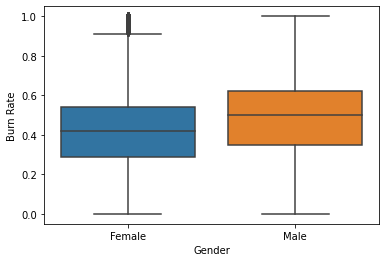

In [8]:
sns.boxplot(x = 'Gender', y = 'Burn Rate',data = df);

Burn Rate among the male employees is higher than that in female employees. Lets find the possible reasons by comparing other factors such as designation, working hours etc. among the two genders in the company.

**Note** - The boxplot shows that there are outliers in the burn rate records of female employees. We'll have to take care of it.

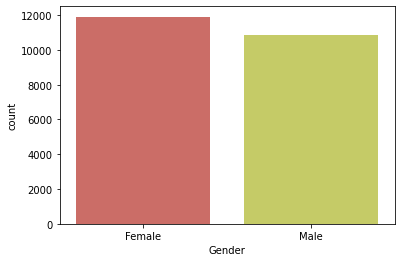

In [9]:
sns.countplot(x = 'Gender',palette=sns.color_palette("hls"),data = df);

The data has more records of female employees.

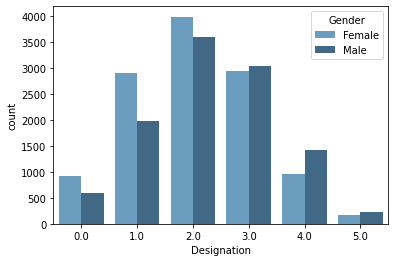

In [10]:
sns.countplot(x = 'Designation',hue = 'Gender',palette='Blues_d',data = df);

There are more males working at higher desination (>2.0). While there are more feamales at lower designation.

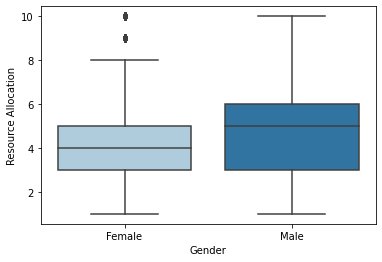

In [11]:
sns.boxplot(x = 'Gender', y = 'Resource Allocation',palette=sns.color_palette("Paired"),data = df);

**Note** - Again we observe outliers in the feature - Resource Allocation in the female records.

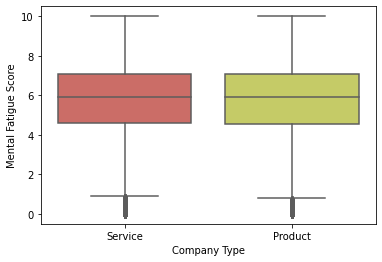

In [12]:
sns.boxplot(x = 'Company Type', y = 'Mental Fatigue Score',palette=sns.color_palette("hls"),data = df);

The fatigue scores remain equal for the two types of comapnies.
**Note** - Outliers

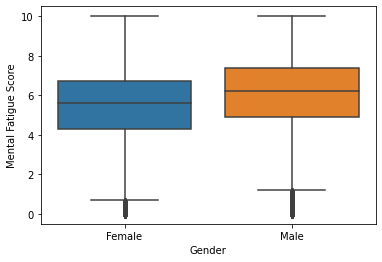

In [13]:
sns.boxplot(x = 'Gender', y = 'Mental Fatigue Score',data = df);

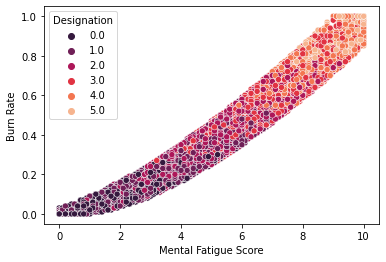

In [14]:
sns.scatterplot(x = 'Mental Fatigue Score', y = 'Burn Rate',hue = 'Designation',palette=sns.color_palette("rocket"),data = df);

Indicates a very strong linear relationship between the featigue scores and burn rate. 

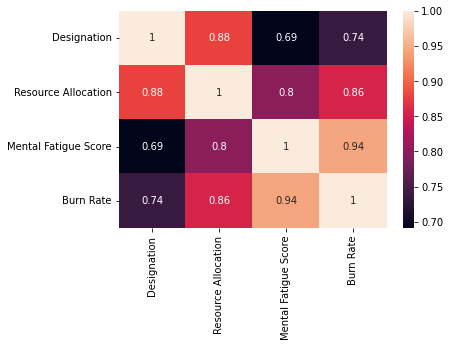

In [15]:
sns.heatmap(df.corr(),annot = True)

Apart from Mental Fatigue Score, Burn Rate shows a strong positive linear relationship with Resource Allocation.

# **Categorical Encoding**

In [16]:
df.drop('Employee ID',axis=1,inplace=True)


We will be using 'Date of Joining' in the feature engineering to create an important feature.

In [17]:
dat = pd.Series(df['Date of Joining'])
df.drop('Date of Joining',axis=1,inplace=True)

In [18]:
cat = []
num = []
for feat in df.columns:
  if(df[feat].dtype=='object'):
    cat.append(feat)
  else:
    num.append(feat)


In [19]:
cat

['Gender', 'Company Type', 'WFH Setup Available']

In [20]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
dummy_df = pd.DataFrame(encoder.fit_transform((df[cat])))
dummy_df.index = df.index
dummy_df.columns = encoder.get_feature_names(cat)

In [21]:
df.drop(cat,axis=1,inplace = True)
df = pd.concat([df,dummy_df],axis=1)

In [22]:
df.head()

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Gender_Female,Gender_Male,Company Type_Product,Company Type_Service,WFH Setup Available_No,WFH Setup Available_Yes
0,2.0,3.0,3.8,0.16,1.0,0.0,0.0,1.0,1.0,0.0
1,1.0,2.0,5.0,0.36,0.0,1.0,0.0,1.0,0.0,1.0
2,2.0,NaN,5.8,0.49,1.0,0.0,1.0,0.0,0.0,1.0
3,1.0,1.0,2.6,0.20,0.0,1.0,0.0,1.0,0.0,1.0
4,3.0,7.0,6.9,0.52,1.0,0.0,0.0,1.0,1.0,0.0


In [23]:
#drop Gender Male and WFH Setup Available_No as their information is already there in their other feature.
df.drop(['WFH Setup Available_No','Gender_Male','Company Type_Product'],axis=1,inplace=True)

**Null Value Imputation**

In [24]:
df.isnull().sum()

Designation                   0
Resource Allocation        1381
Mental Fatigue Score       2117
Burn Rate                  1124
Gender_Female                 0
Company Type_Service          0
WFH Setup Available_Yes       0
dtype: int64

The null values in all the columns are missing at random. Probably the employees didn't want to share/ hesitated to share the information like stress score, burn rate and the working hours.

There are missing values in Burn Rate and mental fatigue scores. Lets visualize their distribution.

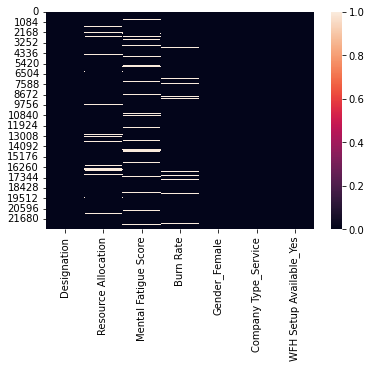

In [25]:
sns.heatmap(df.isnull())

In [26]:
df[df['Burn Rate'].isnull()]['Mental Fatigue Score'].isnull().sum()

172

We observe that the null values in the two features donot occour simultaneously for a given sample. So we impute the missing value of target with mental fatigue score and vice versa due to their strong collinearity. We will use median/mean imputation for rest of the null values (Where null values occour simultaneously).

**Lets use linear regression for this task.**

In [27]:
x1 = pd.DataFrame(df[df['Burn Rate'].isnull()]['Mental Fatigue Score'])

In [28]:
x1['Mental Fatigue Score'].fillna(x1['Mental Fatigue Score'].median(),inplace=True)

In [29]:
df_new = df[['Mental Fatigue Score','Burn Rate']]
df_new.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [30]:
df_new

,Mental Fatigue Score,Burn Rate
0,3.8,0.16
1,5.0,0.36
2,5.8,0.49
3,2.6,0.20
4,6.9,0.52
...,...,...
22743,6.0,0.48
22744,6.2,0.54
22746,6.7,0.59
22748,5.9,0.52


In [31]:
df_new.isnull().sum()

Mental Fatigue Score    0
Burn Rate               0
dtype: int64

In [32]:
X = df_new[['Mental Fatigue Score']] # X.shape should be (N, M) where M >= 1
y = df_new['Burn Rate']
model = LinearRegression()
model.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [33]:
print("Regression Intercept: ",model.intercept_)
print("Regression Coefficient: ",model.coef_)

Regression Intercept:  -0.10541529584191184
Regression Coefficient:  [0.0972793]


In [34]:
pred = model.predict(x1) #the values to be filled in nan values of burn rate

In [35]:
ind = df[df['Burn Rate'].isnull()].index
for j,i in enumerate(ind):
  df['Burn Rate'].iloc[i] = pred[j]

In [36]:
X = df_new[['Burn Rate']] # X.shape should be (N, M) where M >= 1
y = df_new['Mental Fatigue Score']
model = LinearRegression()
model.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [37]:
x2 = pd.DataFrame(df[df['Mental Fatigue Score'].isnull()]['Burn Rate'])
x2.isnull().sum()

Burn Rate    0
dtype: int64

In [38]:
pred = model.predict(x2)
ind = df[df['Mental Fatigue Score'].isnull()].index
for j,i in enumerate(ind):
  df['Mental Fatigue Score'].iloc[i] = pred[j]

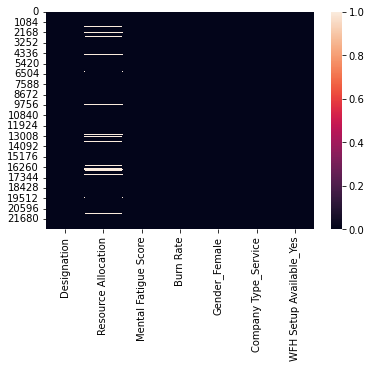

In [39]:
sns.heatmap(df.isnull())

In [40]:
x3 = pd.DataFrame(df[df['Mental Fatigue Score'].isnull()]['Mental Fatigue Score'])

In [41]:
#Lets again use Linear Regression to fill the null values of Resource Allocation. We use the variable with highest correlation with resource reallocation
df_new = df[['Designation','Resource Allocation']]
df_new.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [42]:
X = df_new[['Designation']]
y = df_new['Resource Allocation']
model = LinearRegression()
model.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [43]:
des = pd.DataFrame(df[df['Resource Allocation'].isnull()]['Designation'])
pred2 = model.predict(des)
ind = df[df['Resource Allocation'].isnull()].index
for j,i in enumerate(ind):
  df['Resource Allocation'].iloc[i] = pred2[j]

In [44]:
df.isnull().sum()

Designation                0
Resource Allocation        0
Mental Fatigue Score       0
Burn Rate                  0
Gender_Female              0
Company Type_Service       0
WFH Setup Available_Yes    0
dtype: int64

The null values have been removed. So the EDA and Data Preperation part has been done. Lets move to Feature Engineering process.

# **Feature Engineering**

In [45]:
present = date.today()

In [46]:
date_df = pd.DataFrame(dat) 
date_df

,Date of Joining
0,2008-09-30
1,2008-11-30
2,2008-03-10
3,2008-11-03
4,2008-07-24
...,...
22745,2008-12-30
22746,2008-01-19
22747,2008-11-05
22748,2008-01-10


In [47]:
date_df['Date of Joining'] = date_df['Date of Joining'].apply(lambda x : datetime.strptime(x,"%Y-%m-%d").date())

In [48]:
df['Days Spent'] = present - date_df['Date of Joining'] #Get the total number of days spent in the company

In [49]:
df['Days Spent'] = df['Days Spent'].apply(lambda x : int(str(x).split(" ")[0]))

In [50]:
df['Days Spent']

0        4740
1        4679
2        4944
3        4706
4        4808
         ... 
22745    4649
22746    4995
22747    4704
22748    5004
22749    5008
Name: Days Spent, Length: 22750, dtype: int64

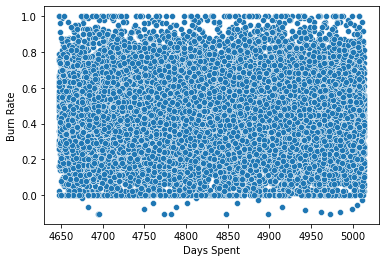

In [51]:
sns.scatterplot(x = df['Days Spent'],y = df['Burn Rate']);

In [52]:
df.drop('Days Spent',axis=1,inplace=True)

However the scatterplot shows that there are no trends in the data of Burn Rate vs Time Spent. So we drop the feature Time Spent as it has no importance in the data.

Earlierly we had observed there were outliers in few features. Lets try to remove the skewness caused.


Lets remove skewness from the data.

In [53]:
for feat in num:
    if((np.abs(df[feat].skew())>0.5)):
        print(feat)
        df[feat] =np.log1p(df[feat])[0]

The |8skewness| >0.5 is significant. However there are no such variable which is skewed.

In [54]:
df['Mental Fatigue Score'].skew()

-0.3974962667775253

In [55]:
df.columns

Index(['Designation', 'Resource Allocation', 'Mental Fatigue Score',
       'Burn Rate', 'Gender_Female', 'Company Type_Service',
       'WFH Setup Available_Yes'],
      dtype='object')

No new features can be created.


In [56]:
l = [1,2,3,5,7]
arr = np.array(l)
arr.shape

(5,)

In [57]:
arr = arr.reshape(-1,1)

In [58]:
arr.shape

(5, 1)

In [59]:
df.describe()

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Gender_Female,Company Type_Service,WFH Setup Available_Yes
count,22750.000000,22750.000000,22750.000000,22750.000000,22750.000000,22750.000000,22750.000000
mean,2.178725,4.481115,5.729033,0.451909,0.523429,0.652000,0.540220
std,1.135145,2.031727,1.908012,0.197016,0.499462,0.476346,0.498391
min,0.000000,1.000000,0.000000,-0.105415,0.000000,0.000000,0.000000
25%,1.000000,3.000000,4.600000,0.320000,0.000000,0.000000,0.000000
50%,2.000000,4.198186,5.800000,0.450000,1.000000,1.000000,1.000000
75%,3.000000,6.000000,7.087365,0.590000,1.000000,1.000000,1.000000
max,5.000000,10.000000,10.755840,1.000000,1.000000,1.000000,1.000000


# **Model building and evaluation**

Lets find the performance of different ensemble techniques on the data -> 1.XGBoost 2.AdaBoost 3.RandomForest. Metric -> R2 Score.

In [60]:

model1 = XGBRegressor()
X = df.drop('Burn Rate',axis=1)
y = df['Burn Rate']
score = cross_val_score(model1,X,y,cv = 5,scoring = 'r2')

[03:55:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:55:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:55:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:55:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:55:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [61]:
score.mean()

0.9323452606723368

In [62]:
model1.fit(X,y)

[03:55:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [63]:
model2 = AdaBoostRegressor()
score = cross_val_score(model2,X,y,cv = 5,scoring = 'r2')

In [64]:
score.mean()

0.9136577199841481

In [65]:
from sklearn.ensemble import RandomForestRegressor
model3 = RandomForestRegressor()
score = cross_val_score(model3,X,y,cv = 5,scoring = 'r2')

In [66]:
score.mean()

0.9218468275210399

In [67]:
regressor = XGBRegressor()

# **Hyperparameter tuning**

In [69]:
param_grid = {
    "colsample_bytree" : np.arange(0.1,1,0.1),
    "gamma" : np.arange(0.01,0.1,0.01),
    "learning_rate" : np.arange(0.01,0.1,0.01),
    "max_depth" : np.arange(2,10),
    "n_estimators" : np.arange(1500,2500,100),
    "reg_alpha" : np.arange(0,1,0.1),
     "reg_lambda" : np.arange(0,1,0.1),
    "subsample" : np.arange(0.1,1,0.1), 
      "silent"  : [1],
    "nthread" : [-1],
}
model  = RandomizedSearchCV(
    estimator= regressor,
    param_distributions= param_grid,
    n_iter=20,
    scoring = 'r2',
    verbose= 3,
    n_jobs=1,
    cv = 5
    )
model.fit(X,y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] subsample=0.6, silent=1, reg_lambda=0.0, reg_alpha=0.7000000000000001, nthread=-1, n_estimators=2300, max_depth=2, learning_rate=0.06999999999999999, gamma=0.01, colsample_bytree=0.4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.6, silent=1, reg_lambda=0.0, reg_alpha=0.7000000000000001, nthread=-1, n_estimators=2300, max_depth=2, learning_rate=0.06999999999999999, gamma=0.01, colsample_bytree=0.4, score=0.932, total=  10.5s
[CV] subsample=0.6, silent=1, reg_lambda=0.0, reg_alpha=0.7000000000000001, nthread=-1, n_estimators=2300, max_depth=2, learning_rate=0.06999999999999999, gamma=0.01, colsample_bytree=0.4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.5s remaining:    0.0s


[CV]  subsample=0.6, silent=1, reg_lambda=0.0, reg_alpha=0.7000000000000001, nthread=-1, n_estimators=2300, max_depth=2, learning_rate=0.06999999999999999, gamma=0.01, colsample_bytree=0.4, score=0.931, total=  10.4s
[CV] subsample=0.6, silent=1, reg_lambda=0.0, reg_alpha=0.7000000000000001, nthread=-1, n_estimators=2300, max_depth=2, learning_rate=0.06999999999999999, gamma=0.01, colsample_bytree=0.4 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   20.9s remaining:    0.0s


[CV]  subsample=0.6, silent=1, reg_lambda=0.0, reg_alpha=0.7000000000000001, nthread=-1, n_estimators=2300, max_depth=2, learning_rate=0.06999999999999999, gamma=0.01, colsample_bytree=0.4, score=0.931, total=  10.5s
[CV] subsample=0.6, silent=1, reg_lambda=0.0, reg_alpha=0.7000000000000001, nthread=-1, n_estimators=2300, max_depth=2, learning_rate=0.06999999999999999, gamma=0.01, colsample_bytree=0.4 
[CV]  subsample=0.6, silent=1, reg_lambda=0.0, reg_alpha=0.7000000000000001, nthread=-1, n_estimators=2300, max_depth=2, learning_rate=0.06999999999999999, gamma=0.01, colsample_bytree=0.4, score=0.933, total=  10.4s
[CV] subsample=0.6, silent=1, reg_lambda=0.0, reg_alpha=0.7000000000000001, nthread=-1, n_estimators=2300, max_depth=2, learning_rate=0.06999999999999999, gamma=0.01, colsample_bytree=0.4 
[CV]  subsample=0.6, silent=1, reg_lambda=0.0, reg_alpha=0.7000000000000001, nthread=-1, n_estimators=2300, max_depth=2, learning_rate=0.06999999999999999, gamma=0.01, colsample_bytree=0.4

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 21.7min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=...
                                        'n_estimators': array([1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400]),
                                        'nthread': [-1],
      

In [71]:
model.best_score_

0.9327164102350214

The hyperparameter tuning has improved model's score. So we go with the optimized XGBoost for the final stage--> **Deployment**!

In [78]:
filename = 'bunrout_model_xgb.pkl'
pickle.dump(model, open(filename, 'wb'))

In [79]:
user = np.array([[2],[3],[6],[1],[1],[1]])
user = user.reshape(1,6)

In [80]:
loaded_model = pickle.load(open('/content/bunrout_model_xgb.pkl', 'rb'))

[04:26:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [81]:
test = pd.DataFrame(user,columns = ['Designation', 'Resource Allocation', 'Mental Fatigue Score', 'Gender_Female', 'Company Type_Service', 'WFH Setup Available_Yes'])

In [82]:
test

,Designation,Resource Allocation,Mental Fatigue Score,Gender_Female,Company Type_Service,WFH Setup Available_Yes
0,2,3,6,1,1,1


In [83]:
loaded_model.predict(test)

array([0.43553963], dtype=float32)